# Mean-reversion

Mean reversion refers to the tendency of asset prices or values to return to their historical average over time, making deviations from this average temporary and subject to correction. If a price series is mean reverting, then  the current price level will tell us something about what the price's next move will be: If the price level is higher than the mean, the next move will be a downward move; if the price level is lower than the mean ,the next move will be an upward move. 



## Imports

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import pandas as pd
from hurst import compute_Hc
from arch.unitroot import VarianceRatio

## Data

First we specify the tickers we are interested in investigating, along with the period and time interval. 

In [49]:
tickers = ['PM', 'KO', 'TMO']
period = '2y'
interval = '1h'
num_decimals = 4

We then download the price series.

In [50]:
prices = [yf.Ticker(t).history(period=period, interval=interval)['Close'] for t in tickers]

In [51]:
prices_df = pd.DataFrame({ticker: price_series[(prices[0].index[:-1])] for ticker, price_series in zip(tickers, prices)})
prices_df

,PM,KO,TMO
2021-12-02 09:30:00-05:00,88.217598,52.970001,627.989990
2021-12-02 10:30:00-05:00,88.400002,52.948399,631.510010
2021-12-02 11:30:00-05:00,88.459999,53.090000,632.780029
2021-12-02 12:30:00-05:00,88.584999,53.169998,630.409973
2021-12-02 13:30:00-05:00,88.669998,53.330002,629.369995
...,...,...,...
2023-12-01 11:30:00-05:00,93.389999,58.505001,497.600006
2023-12-01 12:30:00-05:00,93.699997,58.494999,496.640015
2023-12-01 13:30:00-05:00,93.860001,58.599998,495.375000
2023-12-01 14:30:00-05:00,94.035004,58.535000,495.720001


Plot the price series

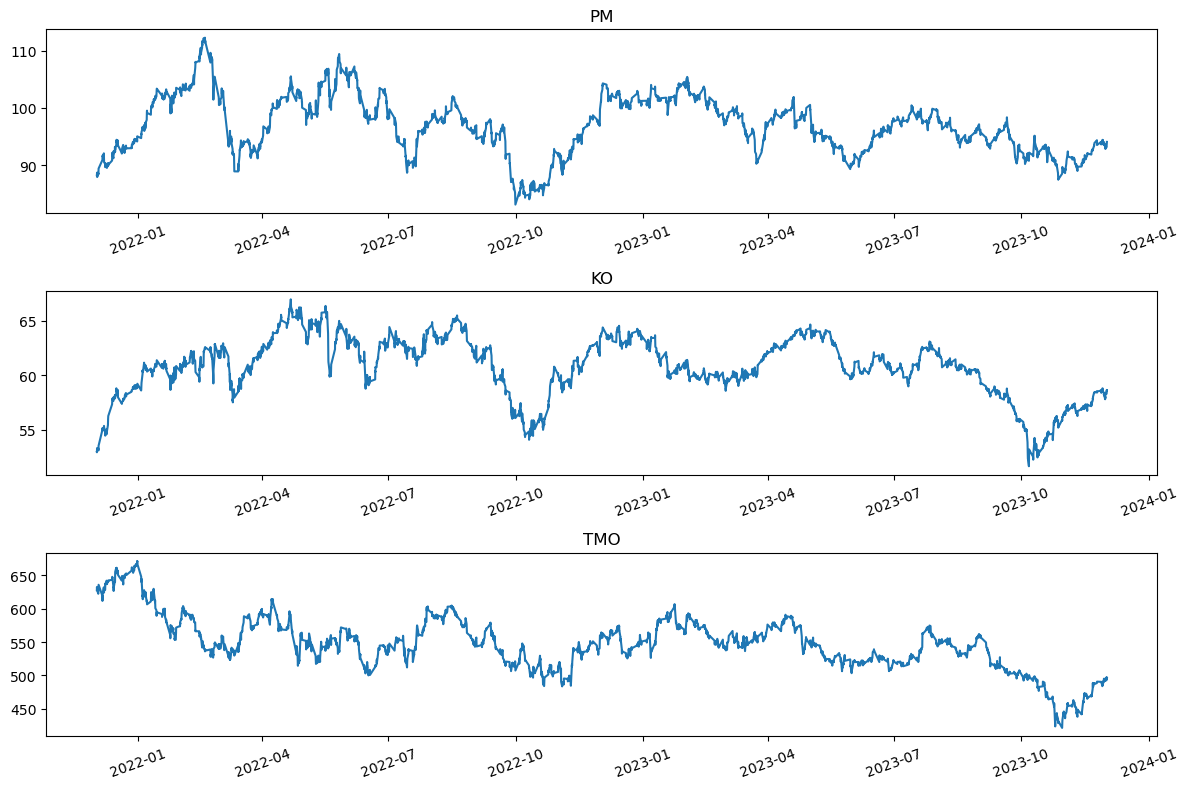

In [57]:
fig, axs = plt.subplots(3, figsize=(12, 8))

for i in range(len(prices)):
    axs[i].plot(prices[i].index, prices[i])
    axs[i].set_title(tickers[i])
    axs[i].tick_params(axis='x', labelrotation=20)

plt.tight_layout()
plt.show()

### ADF test

The mathematical description of a mean-reverting prices series is that the change of the price series in the next period is proportional to the difference between the mean price and the current price. 
This is the basis of the Augmented Dicket-Fuller (ADF) test, which tests whether we can reject the null hypothesis that the proportionality constant is zero. 

We describe price changes using a linear model: 
$$ \Delta R(t) = \lambda R(t-1) + \mu + \beta_t + \alpha_1 \Delta R(t-1) + ... + \alpha_k \Delta R(t-k) + \epsilon_t $$

where $\Delta R(t)=R(t) - R(t-1)$, $\Delta R(t-1) = R(t-1) - R(t-2)$, and so on. The ADF test will find out if $\lambda=0$. If the hypothesis $\lambda=0$ can be rejected, it means the next move $\Delta R(t)$ depends on the current level, and therefore is not a random walk. 


The test statistic $\lambda/ SE(\lambda)$ is a measure of how long it takes for a price to mean revert. 



The null hypothesis is that the unit root (feature of some stochastic processes) is present in the time series $R(t)$, indicating the series is non-stationary. 

The ADF test will give us variables: 
* The ADF (test) statistic,
* The p-value of the test,
* Critical values of 1/5/10% significance level


If the ADF Statistic is less than the critical values and the p-value is less than your chosen significance level (e.g., 0.1), you can reject the null hypothesis, indicating that the time series is stationary.

If the ADF Statistic is greater than the critical values and the p-value is greater than the chosen significance level, you fail to reject the null hypothesis, indicating that the time series is non-stationary.

In [58]:
adf_results_df = pd.concat([
    pd.DataFrame({
        "Ticker": [ticker],
        "ADF Statistic": [round(result[0], num_decimals)],
        "p-value": [round(result[1], num_decimals)],
        "Critical Values (1%/5%/10%)": [list(round(val, num_decimals) for val in result[4].values())]
    })
    for ticker, result in zip(tickers, (adfuller(price) for price in prices))
], ignore_index=True)
adf_results_df.set_index("Ticker", inplace=True)
adf_results_df

,ADF Statistic,p-value,Critical Values (1%/5%/10%)
Ticker,,,
PM,-3.1359,0.0240,"[-3.4322, -2.8624, -2.5672]"
KO,-3.3206,0.0140,"[-3.4322, -2.8624, -2.5672]"
TMO,-2.7729,0.0623,"[-3.4322, -2.8624, -2.5672]"


### Hurst exponent

The Hurst exponent $H$ is a fractal property of a time series $R(t)$ whose increments, after detrending, scale on average as 
$$ | R(t+\tau) - R(t) | \propto \tau^H $$
For
* $H=1/2$ is a Weiner process describing an unpredictable Brownian motion, 
* $H>1/2$ indicates persistence which indicates momentum, 
* $H<1/2$ indicates antipersistence which indicates mean-reversion. 

In [35]:
hurst_results_df = pd.concat([
    pd.DataFrame({
        "Ticker": [ticker],
        "Hurst Exponent": [round(result[0], num_decimals)],
    })
    for ticker, result in zip(tickers, (compute_Hc(price) for price in prices))
], ignore_index=True)
hurst_results_df.set_index("Ticker", inplace=True)
hurst_results_df

,Hurst Exponent
Ticker,
PM,0.4531
KO,0.4670
MCD,0.4934
TMO,0.4479


### Variance ratio

We can test the null hypothesis that a time series is a random walk using a variance ratio test. 

In [36]:
for price, ticker in zip(prices, tickers): 
    vr = VarianceRatio(price)
    print(ticker + vr.summary().as_text())

PM     Variance-Ratio Test Results     
Test Statistic                  0.883
P-value                         0.377
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)
KO     Variance-Ratio Test Results     
Test Statistic                  1.039
P-value                         0.299
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)
MCD     Variance-Ratio Test Results     
Test Statistic                 -0.663
P-value                         0.507
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)
TMO     Variance-Ratio Test Results     
Test Statistic                 -1.935
P-value                         0.053
Lags                                2
-------------------------------------

Computed with overlapping blocks (de-biased)


### Half-life of mean reversion

If we transform the discrete time series from above to a differential form so that the changes in prices becomes infinitesimal quantities (and ignore the drift $\beta_t$ and the lagged differences $\Delta R(t-1), ..., \Delta R(t-k)$) then it becomes recognizable as the Ornstein-Uhlenbeck formula for a mean-reverting process
$$ d R(t) = (\lambda R(t-1) + \mu)dt + d\epsilon $$
where $d \epsilon$ is some Gaussian noise. 
We find the $\lambda$ using the ADF test, where we apply linear regression of $\Delta R(t)$ against $R(t-1)$, and this value carries over to the differential form. 
The analytical solution for the expected value of $R(t)$ is
$$ E[R(t)] = R_0 \exp{(\lambda t)} - \mu / \lambda (1-\exp{(\lambda t)}) $$

Since $\lambda$ is negative for a mean-reverting process, the expected value of the price decays exponentially to the value $-\mu/\lambda$ with the half-life of decay equal to $-\log{(2)}/\lambda$. 
Therefore, a mean-reverting strategy will not work if $\lambda>0$. 
Furthermore, if $\lambda$ is very close to zero, this means that the half-life will be very long, and a mean-reverting strategy will not be very profitable because we won't be able to complete many round-trip trades in a given time period. 
Lastly, $\lambda$ determines a natural time scale for many parameters in our strategy. Often, setting the look-back to equal a small multiple ($\geq 1$) of the half-life is close to optimal. 

In [37]:
def get_halflife(y): 
    ylag = np.roll(y, 1)
    deltaY = y - ylag
    deltaY = deltaY[1:]
    ylag = ylag[1:]
    X = np.column_stack((ylag, np.ones(len(ylag))))
    ols_model = sm.OLS(deltaY, X).fit()
    beta_1 = ols_model.params[0]
    halflife = -np.log(2) / beta_1
    return halflife

In [38]:
half_life_df = pd.concat([
    pd.DataFrame({
        "Ticker": [ticker],
        "Half life": [get_halflife(price)],
    })
    for ticker, price in zip(tickers, prices)
], ignore_index=True)
half_life_df.set_index("Ticker", inplace=True)
half_life_df


,Half life
Ticker,
PM,133.540176
KO,134.732719
MCD,374.420730
TMO,150.166796


### Linear mean-reverting strategy

We define a simple linear strategy for trading mean-reverting price series: 
Determine the normalized deviation of the price from its moving average, and maintain the number of units in this asset negatively proportional to this normalized deviation. 
The lookback for the moving average and standard deviation is set to the half-life. 

$$ mktVal = - (R - MA(R, lookback)) / MSTD(R, lookback) $$

In [39]:
mktVal = [- (price - price.rolling(max(1, round(lookback[0]))).mean()) / price.rolling(max(1, round(lookback[0]))).std() for price, lookback in zip(prices, half_life_df.values)]
#mktVal = [m.clip(-1, 1) for m in mktVal]

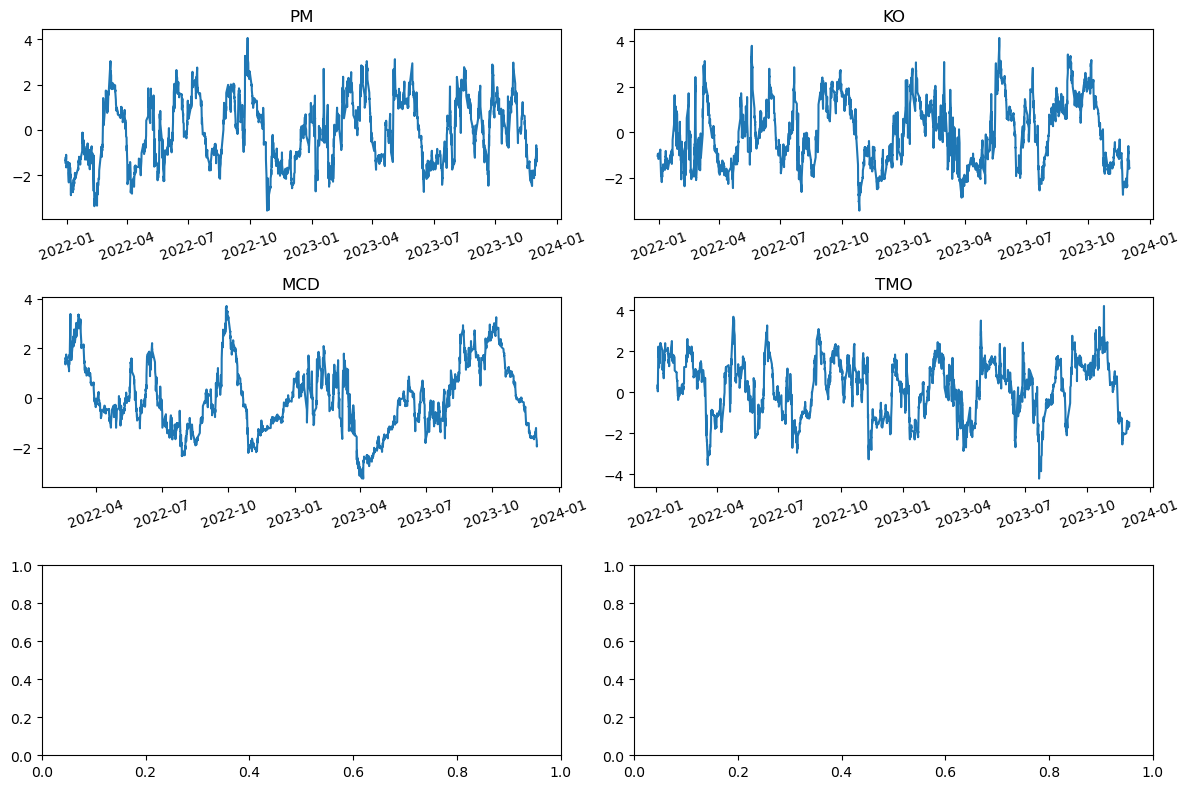

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(12, 8))

for i in range(len(prices)):
    row = i // 2
    col = i % 2
    axs[row, col].plot(mktVal[i].index, mktVal[i])
    axs[row, col].set_title(tickers[i])
    axs[row, col].tick_params(axis='x', labelrotation=20)

plt.tight_layout()
plt.show()

We can then calculate the performance (P&L) of this strategy. Keep in mind that this does not account for transaction costs and assumes a frictionless market. 

In [41]:
pnl = [mval.shift(1) * (price - price.shift(1)) / price.shift(1) for price, mval in zip(prices, mktVal)]
pnl = [p.fillna(0).add(1) for p in pnl]

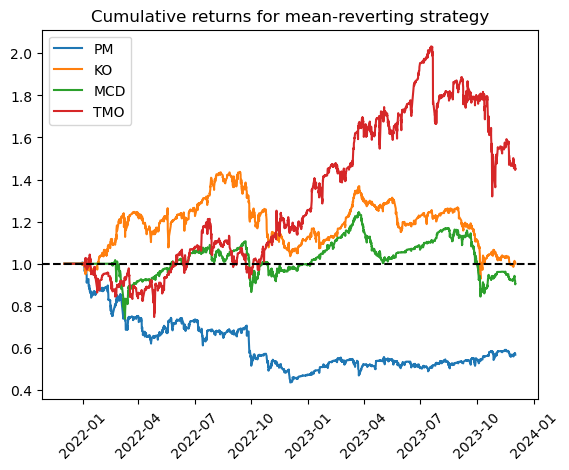

In [42]:
fig, ax = plt.subplots()

for p, ticker in zip(pnl, tickers):
    ax.plot(p.cumprod(), label=ticker)
ax.legend()
plt.title('Cumulative returns for mean-reverting strategy')
ax.axhline(y=1, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()

## Cointegration

We can combine $\geq 2$ individual price series that are not mean reverting into a portfolio whose net market value is mean reverting through cointegration. 

The typical 'pairs trading' strategy is based on cointegration of going long one asset and simultaneously shorting another. 


### CADF test

The cointegrated augmented Dickey-Fuller (CADF) test will tell us what hedge ratios we should use to combine assets to form a stationary portfolio. First we determine the optimal hedge ratio by running a linear regression fit between two price series, and then we use this hedge ratio to form a portfolio. Finally, we run a stationarity test on this portfolio. 

In [43]:
p_cointegration_matrix = np.zeros((len(prices), len(prices)))
for i in range(len(prices)):
    for j in range(i + 1, len(prices)):
        result = sm.tsa.coint(prices[i], prices[j])
        p_cointegration_matrix[i, j] = p_cointegration_matrix[j, i] = round(result[1], num_decimals)
p_cointegration_df = pd.DataFrame(p_cointegration_matrix, columns=tickers, index=tickers)
p_cointegration_df

,PM,KO,MCD,TMO
PM,0.0000,0.0520,0.0768,0.0165
KO,0.0520,0.0000,0.0843,0.0040
MCD,0.0768,0.0843,0.0000,0.6152
TMO,0.0165,0.0040,0.6152,0.0000


We find the optimal hedge ratio using OLS regression. Unfortunately the results are not symmetric (i.e., [i, j] != [j, i]). 

In [44]:
hedge_ratio_matrix = np.zeros((len(prices), len(prices)))
for i in range(len(prices)):
    for j in range(len(prices)):
        if i!=j:
            result = sm.OLS(prices[i][:-1], sm.add_constant(prices[j][:-1])).fit()
            hedge_ratio_matrix[i, j] = round(result.params[1], num_decimals)
hedge_ratio_df = pd.DataFrame(hedge_ratio_matrix, columns=tickers, index=tickers)
hedge_ratio_df

,PM,KO,MCD,TMO
PM,0.0000,1.1673,-0.0061,0.0464
KO,0.3486,0.0000,0.0243,0.0249
MCD,-0.0705,0.9474,0.0000,-0.0252
TMO,3.0170,5.4251,-0.1411,0.0000


We can visualize the cointegrated portfolio of two assets combined with the hedge ratio found above. 

In [45]:
hedged_portfolio_matrix = []
hedged_portfolio_titles = []
for i in range(len(prices)):
    for j in range(len(prices)):
        if i!=j:
            hedged_portfolio_matrix.append(prices[i][:-1] - hedge_ratio_df[tickers[i]][tickers[j]] * prices[j][:-1])
            sign = '+' if hedge_ratio_df[tickers[i]][tickers[j]] < 0 else '-'
            hedged_portfolio_titles.append(f'{tickers[i]} {sign} {abs(hedge_ratio_df[tickers[i]][tickers[j]])} * {tickers[j]}')
hedged_portfolio_df = pd.concat(hedged_portfolio_matrix, axis=1)
hedged_portfolio_df.columns = hedged_portfolio_titles
hedged_portfolio_df

,PM - 0.3486 * KO,PM + 0.0705 * MCD,PM - 3.017 * TMO,KO - 1.1673 * PM,KO - 0.9474 * MCD,KO - 5.4251 * TMO,MCD + 0.0061 * PM,MCD - 0.0243 * KO,MCD + 0.1411 * TMO,TMO - 0.0464 * PM,TMO - 0.0249 * KO,TMO + 0.0252 * MCD
2021-12-02 09:30:00-05:00,69.752256,105.792542,-1806.428203,-50.006401,-183.207338,-3353.938495,249.828121,248.002822,337.899381,623.896694,626.671037,634.272098
2021-12-02 10:30:00-05:00,69.942190,105.964371,-1816.865698,-50.240923,-183.086837,-3373.056555,249.679239,247.853353,338.246062,627.408250,630.191595,637.788338
2021-12-02 11:30:00-05:00,69.952825,106.032124,-1820.637349,-50.169357,-183.049450,-3379.804937,249.789606,247.959913,338.535262,628.675485,631.458088,639.061129
2021-12-02 12:30:00-05:00,70.049938,106.149369,-1813.361890,-50.235271,-182.865237,-3366.867147,249.680368,247.847968,338.090847,626.299629,629.086040,636.688301
2021-12-02 13:30:00-05:00,70.079160,106.302049,-1810.139277,-50.174487,-183.614744,-3361.065159,250.640893,248.804087,338.904112,625.255707,628.042078,635.672515
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01 11:30:00-05:00,72.995156,113.481794,-1407.869219,-50.509145,-211.494516,-2641.024792,285.559669,283.568319,355.201351,493.266710,496.143232,504.781754
2023-12-01 12:30:00-05:00,73.308640,113.841142,-1404.662927,-50.881008,-212.167709,-2635.826745,286.261572,284.268574,355.765909,492.292335,495.183489,503.839403
2023-12-01 13:30:00-05:00,73.432041,114.042741,-1400.686374,-50.962780,-212.621672,-2628.858914,286.852545,284.856019,356.177411,491.019896,493.915860,502.589256
2023-12-01 14:30:00-05:00,73.629703,114.215276,-1401.552240,-51.232060,-212.653509,-2630.795579,286.818609,284.822595,356.191087,491.356777,494.262480,502.933375


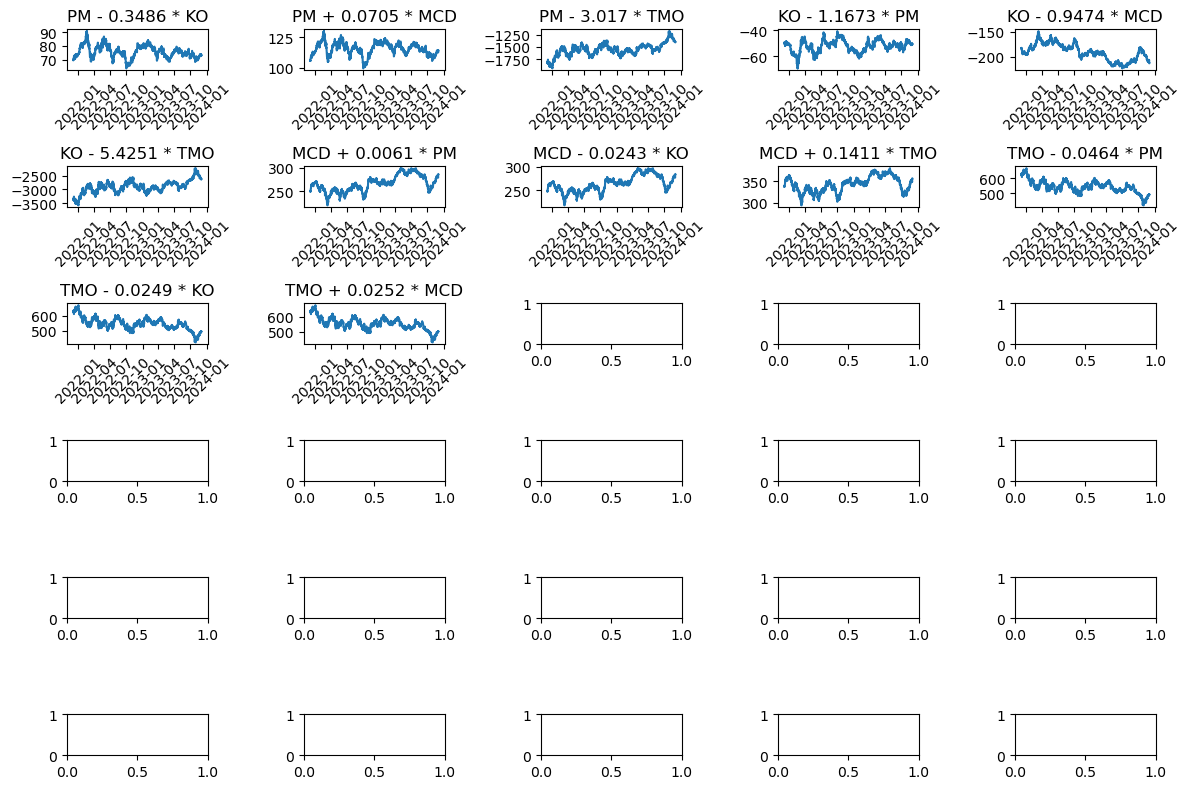

In [46]:
fig, axs = plt.subplots(6, 5, figsize=(12, 8))
col, row = 0, 0

for portfolio in hedged_portfolio_df:
        axs[row, col].plot(hedged_portfolio_df.index, hedged_portfolio_df[portfolio])
        axs[row, col].set_title(portfolio)
        axs[row, col].tick_params(axis='x', labelrotation=45)
        
        col+=1
        if col >= 5:
            col=0
            row+=1

plt.tight_layout()
plt.show()

We see that these price series look more stationary. Now we can run a ADF test on these hedged portfolios. 

In [47]:
adf_hedged_portfolio_results_df = pd.concat([
    pd.DataFrame({
        "Ticker": [ticker],
        "ADF Statistic": [round(result[0], num_decimals)],
        "p-value": [round(result[1], num_decimals)],
        "Critical Values (1%/5%/10%)": [list(round(val, num_decimals) for val in result[4].values())]
    })
    for ticker, result in zip(hedged_portfolio_titles, (adfuller(hedged_portfolio_df[x]) for x in hedged_portfolio_df))
], ignore_index=True)
adf_hedged_portfolio_results_df.set_index("Ticker", inplace=True)
adf_hedged_portfolio_results_df

,ADF Statistic,p-value,Critical Values (1%/5%/10%)
Ticker,,,
PM - 0.3486 * KO,-3.2541,0.0171,"[-3.4322, -2.8624, -2.5672]"
PM + 0.0705 * MCD,-3.3420,0.0131,"[-3.4322, -2.8624, -2.5672]"
PM - 3.017 * TMO,-2.8050,0.0576,"[-3.4322, -2.8624, -2.5672]"
KO - 1.1673 * PM,-3.2900,0.0153,"[-3.4322, -2.8624, -2.5672]"
KO - 0.9474 * MCD,-1.4060,0.5794,"[-3.4322, -2.8624, -2.5672]"
KO - 5.4251 * TMO,-2.7881,0.0600,"[-3.4322, -2.8624, -2.5672]"
MCD + 0.0061 * PM,-1.7672,0.3969,"[-3.4322, -2.8624, -2.5672]"
MCD - 0.0243 * KO,-1.7549,0.4031,"[-3.4322, -2.8624, -2.5672]"
MCD + 0.1411 * TMO,-2.2301,0.1955,"[-3.4322, -2.8624, -2.5672]"


### Johansen test

A way of testing cointegration of more than two variables. We do this by generalizing the equation from the ADF test to where $R(t)$ is the vector representing mutiple price series, and the coefficients $\lambda, \alpha$ are matrices. We assume $\beta_t=0$ for simplicity. 

$$ \Delta R(t) = \lambda R(t-1) + \mu + \alpha_1 \Delta R(t-1) + ... + \alpha_k \Delta R(t-k) + \epsilon_t $$

Just as in the univariate case, if $\lambda=0$, we do not have cointegration. 

The number of price series is denoted by $n$. 
Let $r$ be the number of independent portfolios that can be formed by varios linear combinations of the cointegrating price series ($r$ is also the rank of $\lambda$). 

There are two types of Johansen tests/ways of calculating $r$, both of which are based on eigenvector decomposition of $\lambda$. 
We will look at the trace test first: 

In [48]:
result = coint_johansen(prices_df, det_order=0, k_ar_diff=1)
index_j = [f'r<={x}' for x in range(6)]

trace_stats = pd.Series(result.trace_stat, index=index_j, name="Trace Statistics")
critical_values = pd.DataFrame(result.trace_stat_crit_vals, columns=[90,95,99], index=index_j)
critical_values.columns = [f"{alpha}% Significance" for alpha in [90,95,99]]
trace_df = pd.concat([trace_stats, critical_values], axis=1)
trace_df

ValueError: Length of values (4) does not match length of index (6)

We see that the hypothesis $r=0$ is rejected at $95\%$ significance, while we can't reject $r<=1$ at $90\%$ significance. Therefore, we conclude that there is one cointegrating relatinship between our 6 stocks. 

The other type of Johansen test is the eigenvalue test. 

In [ ]:
eigenvalue_stats = pd.Series(result.max_eig_stat, index=index_j, name="Eigenvalue Statistics")
critical_values = pd.DataFrame(result.max_eig_stat_crit_vals, columns=[90,95,99], index=index_j)
critical_values.columns = [f"{alpha}% Significance" for alpha in [90,95,99]]
eigenvalue_df = pd.concat([eigenvalue_stats, critical_values], axis=1)
eigenvalue_df

,Eigenvalue Statistics,90% Significance,95% Significance,99% Significance
r<=0,34.856860,37.2786,40.0763,45.8662
r<=1,24.646521,31.2379,33.8777,39.3693
r<=2,21.557958,25.1236,27.5858,32.7172
r<=3,14.697765,18.8928,21.1314,25.8650
r<=4,6.467623,12.2971,14.2639,18.5200
r<=5,3.023885,2.7055,3.8415,6.6349


For this test we see that we get different result that the trace test, and we can't even reject the null hypothesis $r=0$ at $90\%$ significance. 

A useful by-product is that the eigenvectors found can be used as our hedge ratios for the individual price sereies to form a stationary portfolio. 

In [ ]:
print('Eigenvalues:\n', result.eig)
print('Eigenvectors:\n', result.evec)

Eigenvalues:
 [0.00988158 0.00699721 0.00612305 0.00417864 0.00184093 0.00086113]
Eigenvectors:
 [[ 0.17705074 -0.16170289 -0.18575801 -0.0972628   0.01421568  0.03081229]
 [-0.4989067  -0.14802251  0.40114191  0.12205451 -0.09837544 -0.01396117]
 [ 0.0563424  -0.00116841 -0.02987819  0.01891923 -0.04895465 -0.0152205 ]
 [-0.09445331 -0.0048282   0.01378272  0.01747658  0.04586974 -0.0471242 ]
 [-0.00206334  0.018356   -0.01900803  0.00553457 -0.00657366  0.01355287]
 [-0.0078546   0.01243355 -0.01094012  0.05692433  0.0444675   0.01611409]]


The eigenvectors are ordered in decreasing order of their corresponding eigenvalues. Therefore, the first cointegrating relation is the 'strongest' with the shortest half-life for mean reversion. The first eigenvector is therefore the natural candidate to form a stationary portfolio. 

### Linear mean-reverting trading on a portfolio

We select the 4 most promising cointigrating portfolios and test the same linear strategy on them. 

In [ ]:
num_portfolios=4
best_adf_hedged_portfolio_results_df = adf_hedged_portfolio_results_df.sort_values(by=['ADF Statistic'], inplace=False).copy()[:num_portfolios]
best_adf_hedged_portfolio_results_df


,ADF Statistic,p-value,Critical Values (1%/5%/10%)
Ticker,,,
PM + 0.0705 * MCD,-3.3420,0.0131,"[-3.4322, -2.8624, -2.5672]"
KO - 1.1673 * PM,-3.2900,0.0153,"[-3.4322, -2.8624, -2.5672]"
PM - 0.3486 * KO,-3.2541,0.0171,"[-3.4322, -2.8624, -2.5672]"
CVX + 0.7268 * TMO,-3.2411,0.0177,"[-3.4322, -2.8624, -2.5672]"


In [ ]:
half_life_hedged_portfolio_df = pd.concat([
    pd.DataFrame({
        "Ticker": [portfolio],
        "Half life": [get_halflife(hedged_portfolio_df[portfolio])],
    })
    for portfolio in best_adf_hedged_portfolio_results_df.index
], ignore_index=True)
half_life_hedged_portfolio_df.set_index("Ticker", inplace=True)
half_life_hedged_portfolio_df

,Half life
Ticker,
PM + 0.0705 * MCD,119.366991
KO - 1.1673 * PM,124.489628
PM - 0.3486 * KO,130.430249
CVX + 0.7268 * TMO,127.472496


In [ ]:
mktVal = [- (price - price.rolling(max(1, round(lookback[0]))).mean()) / price.rolling(max(1, round(lookback[0]))).std() for price, lookback in zip((hedged_portfolio_df[portfolio] for portfolio in best_adf_hedged_portfolio_results_df.index), half_life_hedged_portfolio_df.values)]
#mktVal = [m.clip(-1, 1) for m in mktVal]


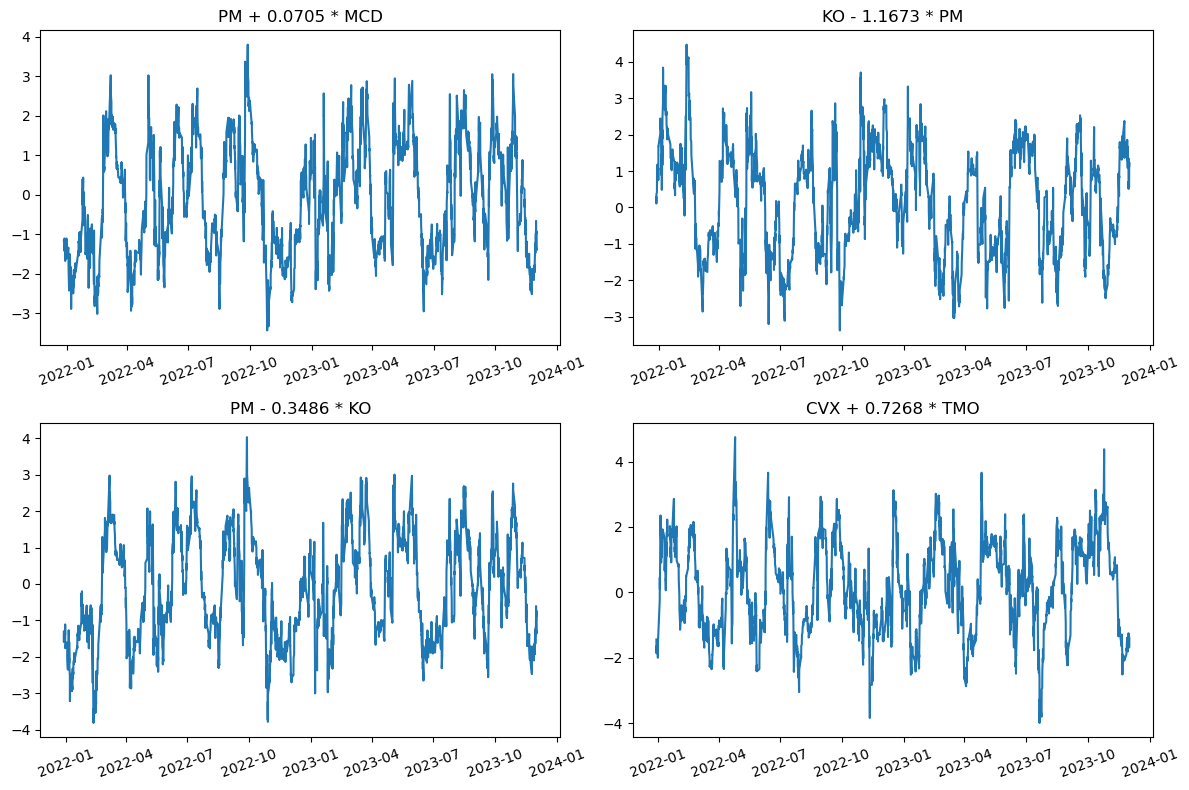

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i in range(len(mktVal)):
    row = i // 2
    col = i % 2
    axs[row, col].plot(mktVal[i].index, mktVal[i])
    axs[row, col].set_title(half_life_hedged_portfolio_df.index[i])
    axs[row, col].tick_params(axis='x', labelrotation=20)

plt.tight_layout()
plt.show()

In [ ]:
pnl = [mval.shift(1) * (price - price.shift(1)) / price.shift(1) for price, mval in zip((hedged_portfolio_df[portfolio] for portfolio in best_adf_hedged_portfolio_results_df.index), mktVal)]
pnl = [p.fillna(0).add(1) for p in pnl]

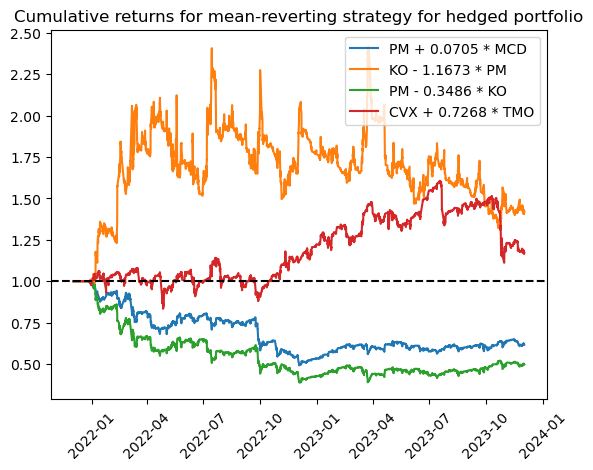

In [ ]:
fig, ax = plt.subplots()

for p, ticker in zip(pnl, half_life_hedged_portfolio_df.index):
    ax.plot(p.cumprod(), label=ticker)
ax.legend()
plt.title('Cumulative returns for mean-reverting strategy for hedged portfolio')
ax.axhline(y=1, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.show()